### Compare theoretical and ground state energy at unit filling

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pimc
import importlib

<module 'pimc' from '/home/ecasiano/LatticePIMC/src/pimc.py'>

### Theoretical ground state energy (no hopping)

In [4]:
def egs_theory(L,U,mu):
    '''Calculates BH model theoretical ground state energy with no hopping'''
    
    # NOTE: This works for unit filling (not sure if otherwise works)
    n_min = 0.5 + mu/U
    egs = L*U/2 * n_min * (n_min-1) - L*mu*n_min
    
    return egs

### Experimental ground state energy

In [3]:
def egs_pimc(data_struct,beta,head_loc,tail_loc,U,mu):
    '''Calculates pimc ground state energy at time slice tau=beta/2'''
    
    # Can only count observables when no worm end is present
    if head_loc != [] or tail_loc != [] : return None

    # Number of lattice sites
    L = len(data_struct)
    
    # BoseHubbard Energy (for no hopping)
    egs = 0
    for i in range(L):
        N_flats = len(data_struct[i]) # Number of flats on site i
        for k in range(N_flats):
            if data_struct[i][k][0] > beta/2: break
            else:
                tau = data_struct[i][k][0]
                n_i = data_struct[i][k][1]
        
        # add energy contribution at 
        egs += (U/2)*n_i*(n_i-1)-mu*n_i

    return egs

### Simulation parameters

In [99]:
# Simulation parameters
N = 4
L = N   # unit-filling
t = 0
U = 1
mu = -0.1
    
# PIMC parameters
beta = 1
eta = 1/np.sqrt(L*beta)      # worm end fugacity

### Create worldline configuration

In [100]:
alpha = []
for i in range(L):
    alpha.append(1)
alpha

[1, 1, 1, 1]

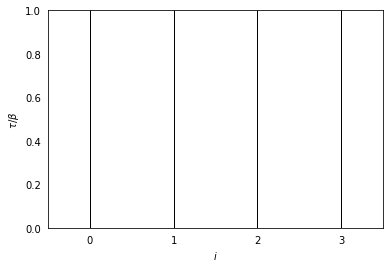

In [135]:
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [156]:
importlib.reload(pimc)
# Do insert many times on the above configuration
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
mc_steps = int(0.01E+02)
for m in range(mc_steps):
    a = 1
    #pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta)
    #pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta)
    #pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu)
    pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)
    #print("Before")
    #pimc.view_worldlines(data_struct,beta,figure_name=None)
    #pimc.delete_gsworm_zero(data_struct, beta, head_loc, tail_loc, U, mu, eta)
    #print("After")
    #pimc.view_worldlines(data_struct,beta,figure_name=None)
    #pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta)
    #pimc.delete_gsworm_beta(data_struct, beta, head_loc, tail_loc, U, mu, eta)

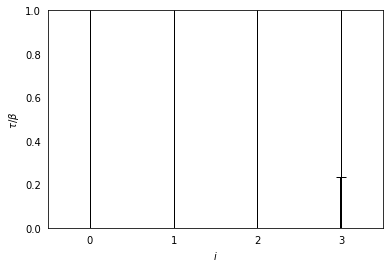

In [157]:
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [ ]:
# NOTE: There is ambiguity when trying to delete single worm ends on
# a flat region. This is causing violation of total particle number.

### For now: Let's test on a configuration with kinks...